<a href="https://colab.research.google.com/github/pmazumder3927/COGS-118B-Final/blob/main/Cogs118B_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import scipy
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize

# Utility functions

In [3]:
# [Vsort,Dsort] = eigsort(V, eigvals)
#
# Sorts a matrix eigenvectors and a array of eigenvalues in order 
# of eigenvalue size, largest eigenvalue first and smallest eigenvalue
# last.
#
# Example usage:
# di, V = np.linarg.eig(L)
# Vnew, Dnew = eigsort(V, di)
#
# Tim Marks 2002
def eigsort(V, eigvals):
    
    # Sort the eigenvalues from largest to smallest. Store the sorted
    # eigenvalues in the column vector lambd.
    lohival = np.sort(eigvals)
    lohiindex = np.argsort(eigvals)
    lambd = np.flip(lohival)
    index = np.flip(lohiindex)
    Dsort = np.diag(lambd)
    
    # Sort eigenvectors to correspond to the ordered eigenvalues. Store sorted
    # eigenvectors as columns of the matrix vsort.
    M = np.size(lambd)
    Vsort = np.zeros((M, M))
    for i in range(M):
        Vsort[:,i] = V[:,index[i]]
    return Vsort, Dsort

In [4]:
# viewcolumn(columnvector);
# VIEWCOLUMN Displays a 60 x 60 grayscale image stored in a column vector.
# Tim Marks 2002

def viewcolumn(columnvector):
    plt.imshow(columnvector.reshape([60, 60], order='F'), cmap=plt.get_cmap('gray'))
# normc(M) normalizes the columns of M to a length of 1.

def normc(Mat):
    return normalize(Mat, norm='l2', axis=0)

In [82]:
def plotCurrent(X, Rnk, Kmus):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1],
                             [1, 1, 1],
                             [0.5, 0.5, 0.5],
                             [0.5, 0.5, 0],
                             [0.5, 0, 0.5],
                             [0, 0.5, 0.5],])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.scatter(X[:,0], X[:,1], c=colorVec)

    plt.scatter(Kmus[:,0], Kmus[:,1], s=200, c=muColorVec, marker='d')
    plt.xlabel('PCA 0')
    plt.ylabel('PCA 1')
    plt.title("K-means clustering (K = " + str(K) + ")")
    plt.axis('equal')
    plt.show()

In [83]:
def plotCurrentGMM(X, Rnk, Kmus, sigma):
    N, D = X.shape
    K = Kmus.shape[0]

    InitColorMat = np.array([[1, 0, 0],
                             [0, 1, 0],
                             [0, 0, 1],
                             [0, 0, 0],
                             [1, 1, 0],
                             [1, 0, 1],
                             [0, 1, 1]])

    KColorMat = InitColorMat[0:K,:]

    colorVec = np.dot(Rnk, KColorMat)
    muColorVec = np.dot(np.eye(K), KColorMat)
    plt.figure(figsize=(10,10))
    ax = plt.gca()
    x,y = np.meshgrid(np.sort(X[:,0]),np.sort(X[:,1]))
    XY = np.array([x.flatten(),y.flatten()]).T
    plt.title("EM Final Clustering")
    for m,c in zip(Kmus, sigma):
        multi_normal = multivariate_normal(mean=m,cov=c)
        cnt = ax.contourf(np.sort(X[:,0]),np.sort(X[:,1]),multi_normal.pdf(XY).reshape(len(X),len(X)),alpha=0.3,levels=np.arange(0,1, 0.1), antialiased=True)
        ax.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    plt.scatter(X[:,0], X[:,1], c=colorVec)
    plt.scatter(Kmus[:,0], Kmus[:,1], c=muColorVec, marker='d')
    plt.show()
    return r

# Loading/preprocessing data

In [84]:
use_h_not_c = False

In [85]:
heart_df = pd.read_csv('https://pastebin.com/raw/eUiVmczJ' if use_h_not_c else 'https://pastebin.com/raw/ig1Mktq2')
heart_df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
...,...,...,...,...,...
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18


In [86]:
heart_categorical_cols = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'] if use_h_not_c else ['Gender']
heart_drop_cols = ['HeartDisease'] if use_h_not_c else ['CustomerID']
# flip this switch for testing
use_categorical_cols = True

if use_categorical_cols:
  # one-hot encoding
  heart_df_dummies = pd.get_dummies(heart_df, columns=heart_categorical_cols)
  # remove the N from the binary categories
  # heart_df_dummies.drop(['ExerciseAngina_N'])
else:
  heart_df_dummies = heart_df.drop(columns=heart_categorical_cols)

heart_df_dummies = heart_df_dummies.drop(columns=heart_drop_cols)

heart = heart_df_dummies.to_numpy()

In [87]:
heart_colnames = heart_df_dummies.columns
heart_colnames

Index(['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender_Female',
       'Gender_Male'],
      dtype='object')

# Principal Component Analysis

In [88]:
# perform PCA
heart_mean = np.mean(heart, axis=0)
heart_ctr = heart - heart_mean
h_eigvals_uns, h_eigvecs_uns = np.linalg.eig(heart_ctr.T @ heart_ctr)
h_eigvecs, h_eigvals_diagmat = eigsort(h_eigvecs_uns, h_eigvals_uns)
h_eigvals_arr = np.diagonal(h_eigvals_diagmat)
heart_pc = heart_ctr @ h_eigvecs
heart_pc = normc(heart_pc)
h_eigvals_arr

array([1.39352637e+05, 1.36182376e+05, 3.32786186e+04, 9.77079704e+01,
       6.43109871e-13])

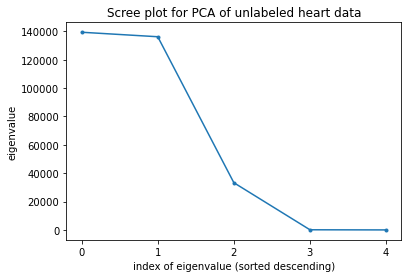

In [89]:
# scree plot
plt.plot(h_eigvals_arr, marker=".")
plt.xticks(range(h_eigvals_arr.shape[0]))
plt.title("Scree plot for PCA of unlabeled heart data")
plt.xlabel("index of eigenvalue (sorted descending)")
plt.ylabel("eigenvalue")
plt.show()

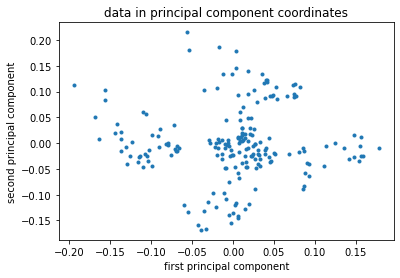

In [90]:
# visualize the first 2 principal components
plt.scatter(heart_pc.T[0], heart_pc.T[1], marker=".")
plt.title("data in principal component coordinates")
plt.xlabel("first principal component")
plt.ylabel("second principal component")
plt.show()

## K-Means Functions

In [91]:
# functions for runKmeans, necessary to find initial Kmus for running GMM

def calcSqDistances(X, Kmus):
    N = len(X)
    K = len(Kmus)

    result = [ [0 for i in range(K)] for j in range(N) ]

    for n in range(N):
        for k in range(K):
            squareDist = np.linalg.norm(X[n]-Kmus[k], 2) ** 2
            result[n][k] = squareDist
    return result

def determineRnk(sqDmat):
    result = np.full_like(sqDmat, 0)

    for n in range(len(sqDmat)):
        index_closestK = sqDmat[n].index(min(sqDmat[n]))
        result[n][index_closestK] = 1
    
    return result

def recalcMus(X, Rnk):
    # Fill this
    result = [0 for i in range(len(Rnk[0]))]

    for k in range(len(Rnk[0])):
        numerator = 0
        denominator = 0
        for n in range(len(Rnk)):
            numerator += X[n] * Rnk[n][k]
            denominator += Rnk[n][k]
        result[k] = numerator/denominator

    return np.asarray(result)

def runKMeans(K,X ):
    #load data file specified by fileString from Bishop book
    # X = np.loadtxt(fileString, dtype='float')

    #determine and store data set information
    N, D = X.shape

    #allocate space for the K mu vectors
    Kmus = np.zeros((K, D))

    #initialize cluster centers by randomly picking points from the data
    rand_inds = np.random.permutation(N)
    Kmus = X[rand_inds[0:K],:]

    #specify the maximum number of iterations to allow
    maxiters = 100000

    for iter in range(maxiters):
        #assign each data vector to closest mu vector as per Bishop (9.2)
        #do this by first calculating a squared distance matrix where the n,k entry
        #contains the squared distance from the nth data vector to the kth mu vector

        #sqDmat will be an N-by-K matrix with the n,k entry as specfied above
        sqDmat = calcSqDistances(X, Kmus)

        #given the matrix of squared distances, determine the closest cluster
        #center for each data vector

        #R is the "responsibility" matrix
        #R will be an N-by-K matrix of binary values whose n,k entry is set as
        #per Bishop (9.2)
        #Specifically, the n,k entry is 1 if point n is closest to cluster k,
        #and is 0 otherwise
        Rnk = determineRnk(sqDmat)

        KmusOld = Kmus
        # plotCurrent(X, Rnk, Kmus)
        # time.sleep(1)

        #recalculate mu values based on cluster assignments as per Bishop (9.4)
        Kmus = recalcMus(X, Rnk)

        #check to see if the cluster centers have converged.  If so, break.
        if np.sum(np.abs(KmusOld.reshape((-1, 1)) - Kmus.reshape((-1, 1)))) < 1e-6:
            # print(iter)
            break

    return Rnk, Kmus

## Error Function

In [92]:
def getClusterSSE(X, Rnk, Kmus):
    result = 0
    for n in range(len(X)):
        for k in range(len(Kmus)):
            result += Rnk[n][k] * (X[n] - Kmus[k]) ** 2
    return result.sum()

## Running K-Means

In [93]:
K_range = range(1, 11)

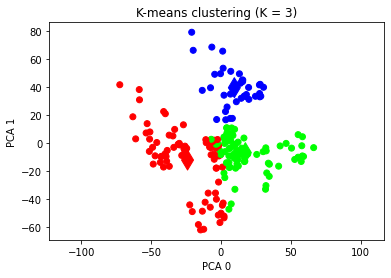

In [94]:
# run K-means just for fun
Rnk, Kmus = runKMeans(K, heart)
X = (heart - heart_mean) @ h_eigvecs
plotCurrent(X, Rnk, (Kmus - heart_mean) @ h_eigvecs)

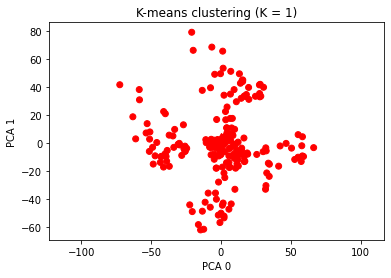

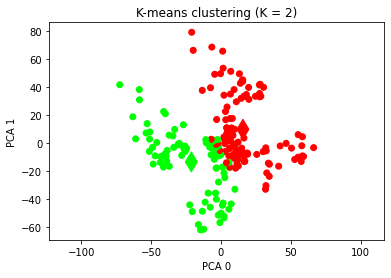

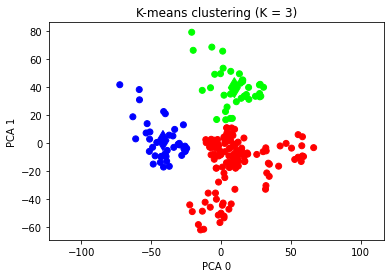

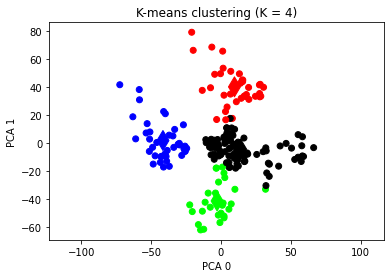

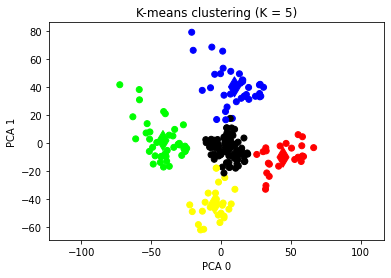

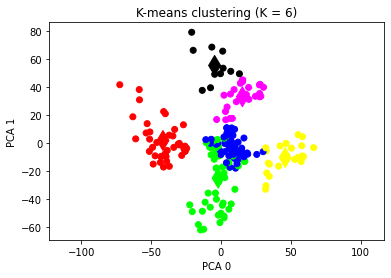

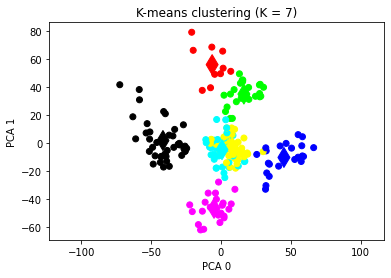

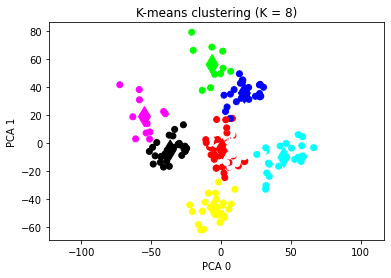

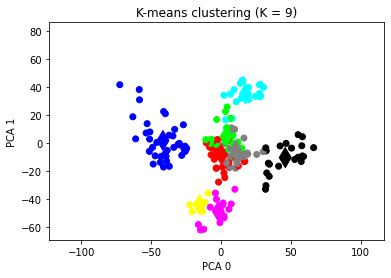

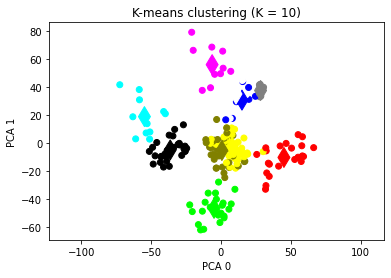

In [95]:
errors = []
k_means_mus = []
for k in K_range:
    Rnk, Kmus = runKMeans(k, heart)
    plotCurrent(X, Rnk, (Kmus - heart_mean) @ h_eigvecs)
    k_means_mus.append(Kmus)
    errors.append(getClusterSSE(heart, Rnk, Kmus))

Text(0, 0.5, 'SSE')

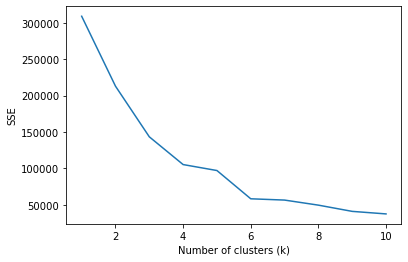

In [41]:
plt.plot(K_range, errors)
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')

## Expectation Maximization with Gaussian Mixture Models

### The below code is adapted from a combination of Pramit's HW5 in this course, as well as Assignment 2 from COGS 188 with Professor Gupta.

In [60]:
class EMModel:
    
    def __init__(self, X, k, max_iters, mu_init=None):
        """
        This function initializes our parameters (mu, pi and sigma) and plots our data points.
        """
        self.X = X
        self.k = k
        self.max_iters = max_iters
        
        self.dim = self.X.shape[1] # Equals 2, as we are considering 2D points
        self.N = self.X.shape[0] # Equals the number of points in the dataset
        
        """
        Here we initialize mu, pi and sigma. Mu is k X 2, Pi is k X 1, Sigma is k X 2 X 2
        """
        if mu_init is None:
            self.mu = np.random.randint(max(min(self.X[:, 0]), min(self.X[:, 1])), min(max(self.X[:, 0]), max(self.X[:, 1])), size=(self.k, self.dim))
        else:
            self.mu = mu_init
        self.pi = np.ones(self.k) / self.k
        self.sigma = np.zeros((self.k, self.dim, self.dim))
        for i in range(self.k):
            np.fill_diagonal(self.sigma[i], 5.0)
            
        """
        This part is required to plot clusters
        """
        x,y = np.meshgrid(np.sort(self.X[:,0]),np.sort(self.X[:,1]))
        self.XY = np.array([x.flatten(),y.flatten()]).T
        
        """
        This variable is required in case the covariance matrix turns out to not be positive semidefinite
        """
        self.sigma_correction = 1e-7*np.identity(self.dim)
            
        # """
        # Finally, let's visualize our data points
        # """
        # self.plot_data('Initial State')

In [61]:
def plot_data(self, title, colors=None):
    """
    This function creates a scatter plot of all the data points. It also creates a contour plot of the probability 
    distributions of each of the clusters (specified by mu, pi and sigma)
    """
    fig = plt.figure(figsize=(20,20))
    ax0 = fig.add_subplot(111)
    ax0.scatter(self.X[:,0], self.X[:,1], c=colors)
    ax0.set_title(title + ' (K = ' + str(self.k) + ')')
    for m,c in zip(self.mu,self.sigma):
        c += self.sigma_correction
        multi_normal = multivariate_normal(mean=m,cov=c)
        ax0.contour(np.sort(self.X[:,0]),np.sort(self.X[:,1]),multi_normal.pdf(self.XY).reshape(len(self.X),len(self.X)),colors='black',alpha=0.3)
        ax0.scatter(m[0],m[1],c='grey',zorder=10,s=100)
    plt.xlabel('PCA 0')
    plt.ylabel('PCA 1')
    plt.show() 
EMModel.plot_data = plot_data

In [62]:
from scipy.stats import multivariate_normal
def expectation(self):
    probabilities = np.array([pi_c*multivariate_normal(mean=mu_c, cov=sigma_c).pdf(self.X) for pi_c, mu_c, sigma_c in zip(self.pi, self.mu, self.sigma+self.sigma_correction)])
    return ( probabilities / np.sum(probabilities, axis=0) ).T
EMModel.expectation = expectation

In [63]:
def maximization(self, r):
    N = np.sum(r, axis=0)
    self.pi = N / np.sum(r)
    self.mu = ( (1/N)*np.apply_along_axis(lambda r: np.sum(self.X*r.reshape(self.N, 1), axis=0), 0, r) ).T
    self.sigma = np.array([ ((1/N[c])*np.dot((r[:,c].reshape(self.N,1)*(self.X-self.mu[c])).T,(self.X-self.mu[c]))) for c in range(self.k)])
EMModel.maximization = maximization

In [64]:
def calc_error(self):
    error = []
    for i in range(len(self.color_labels)):
        center = self.mu[self.color_labels[i]]
        # get the squared error of center to each point
        error.append(np.sum((self.X[i] - center) ** 2))
    return np.sum(error)
EMModel.calc_error = calc_error

In [65]:
def run(self):
    r = None
    for it in range(self.max_iters):
        r = self.expectation()
        self.maximization(r)
    self.r = r
    self.color_labels = np.argmax(r, axis=1)
    self.plot_data('Final Clusters', self.color_labels)
    
EMModel.run = run

## Running EM

1


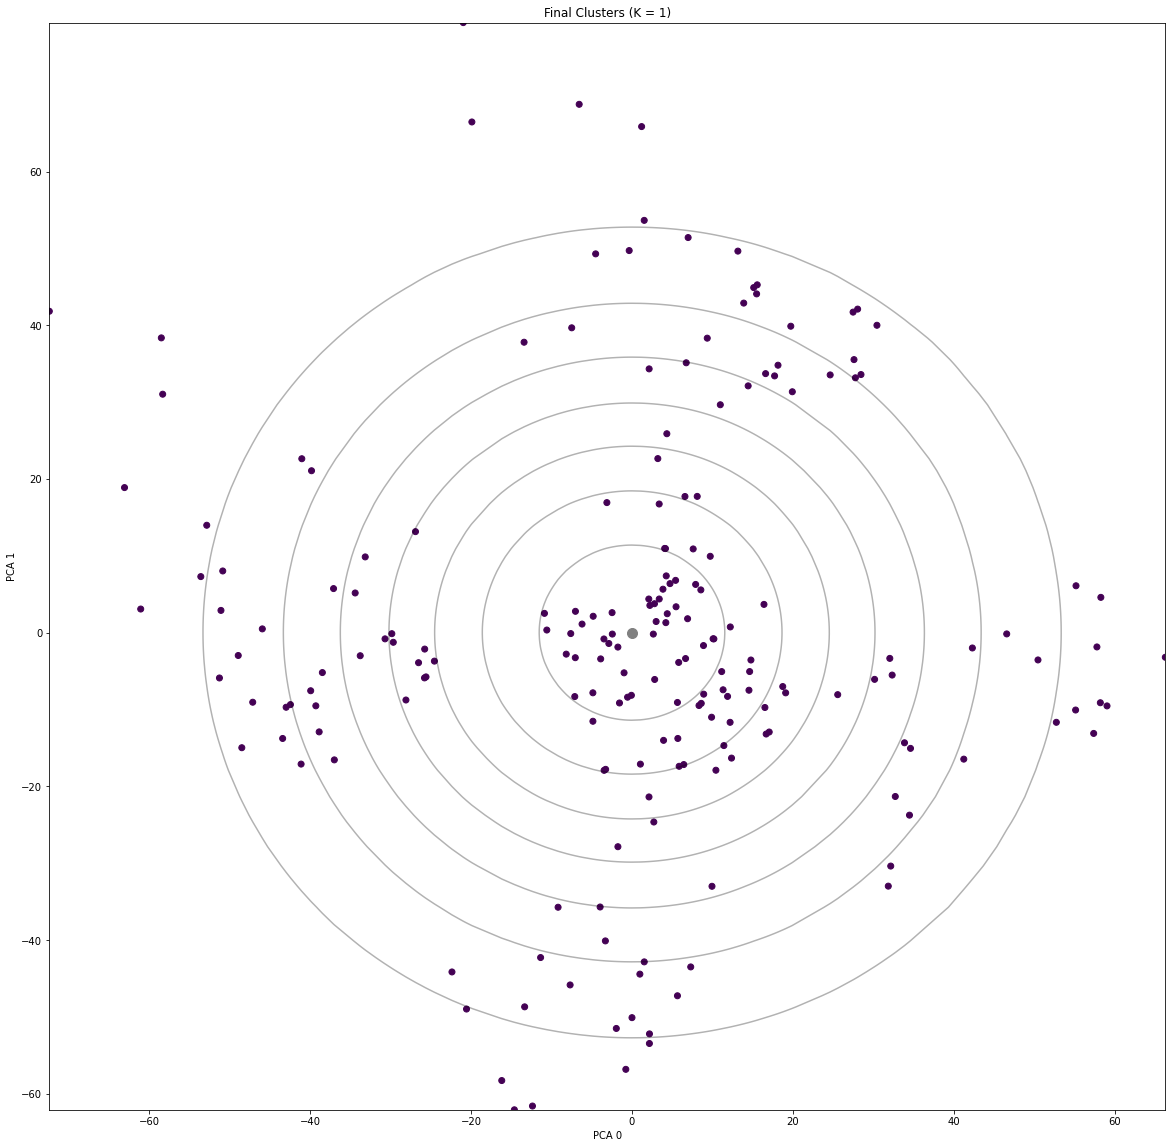

2


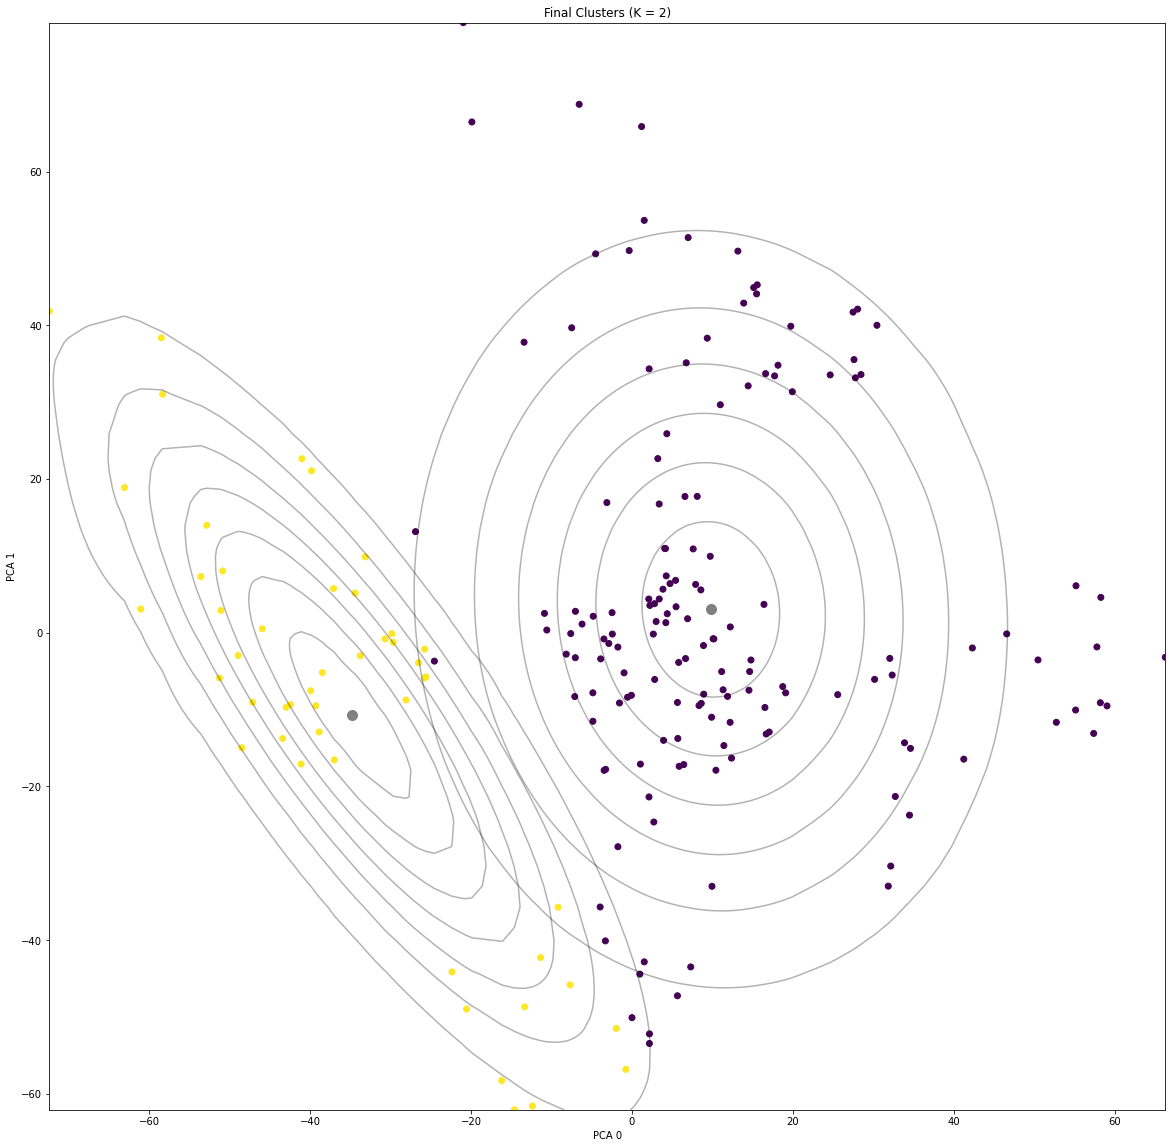

3


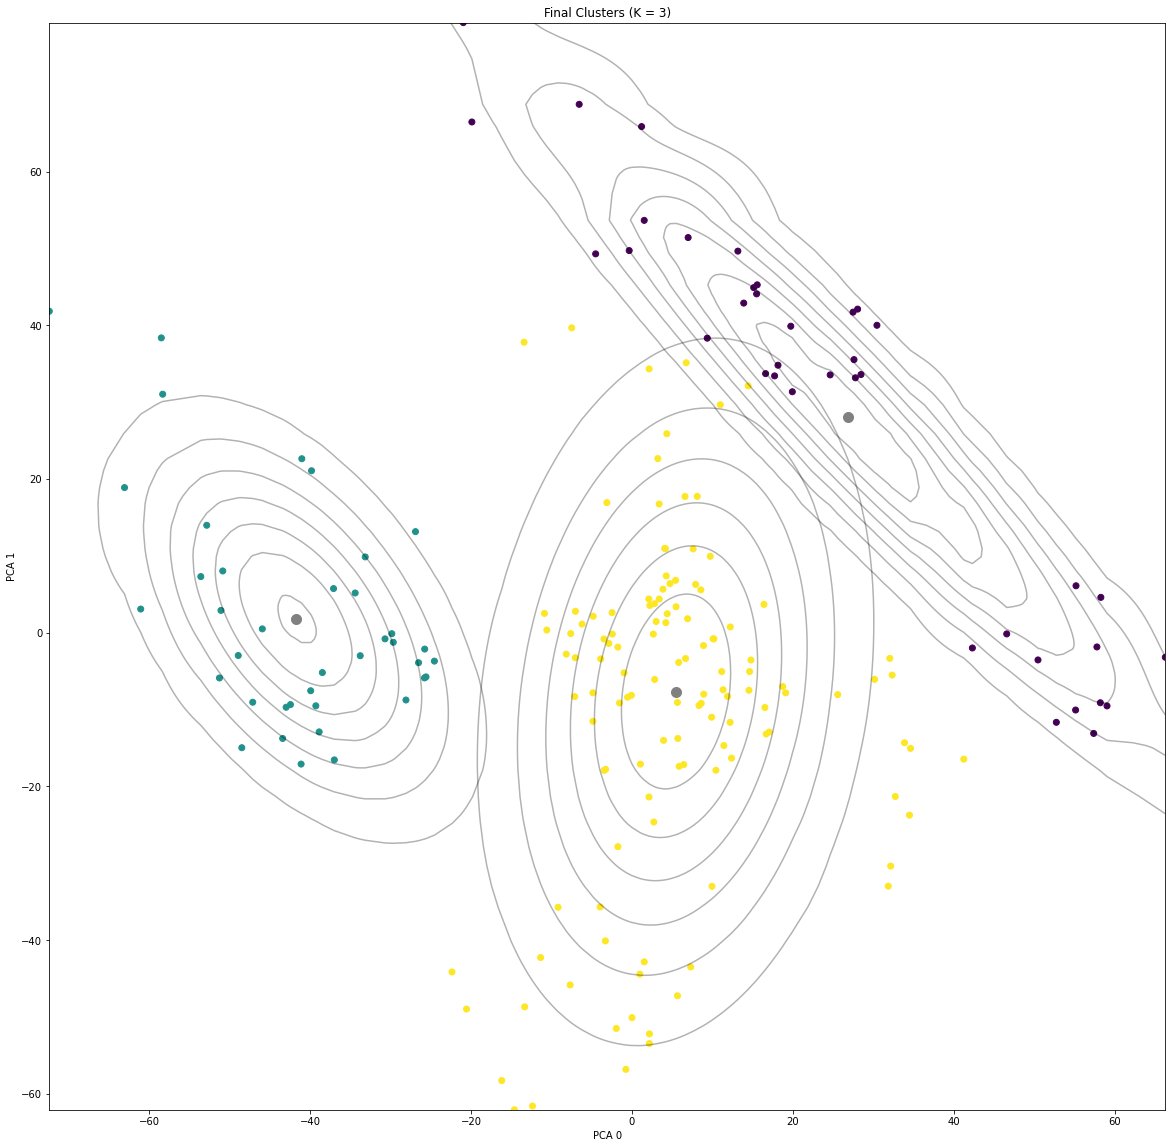

4


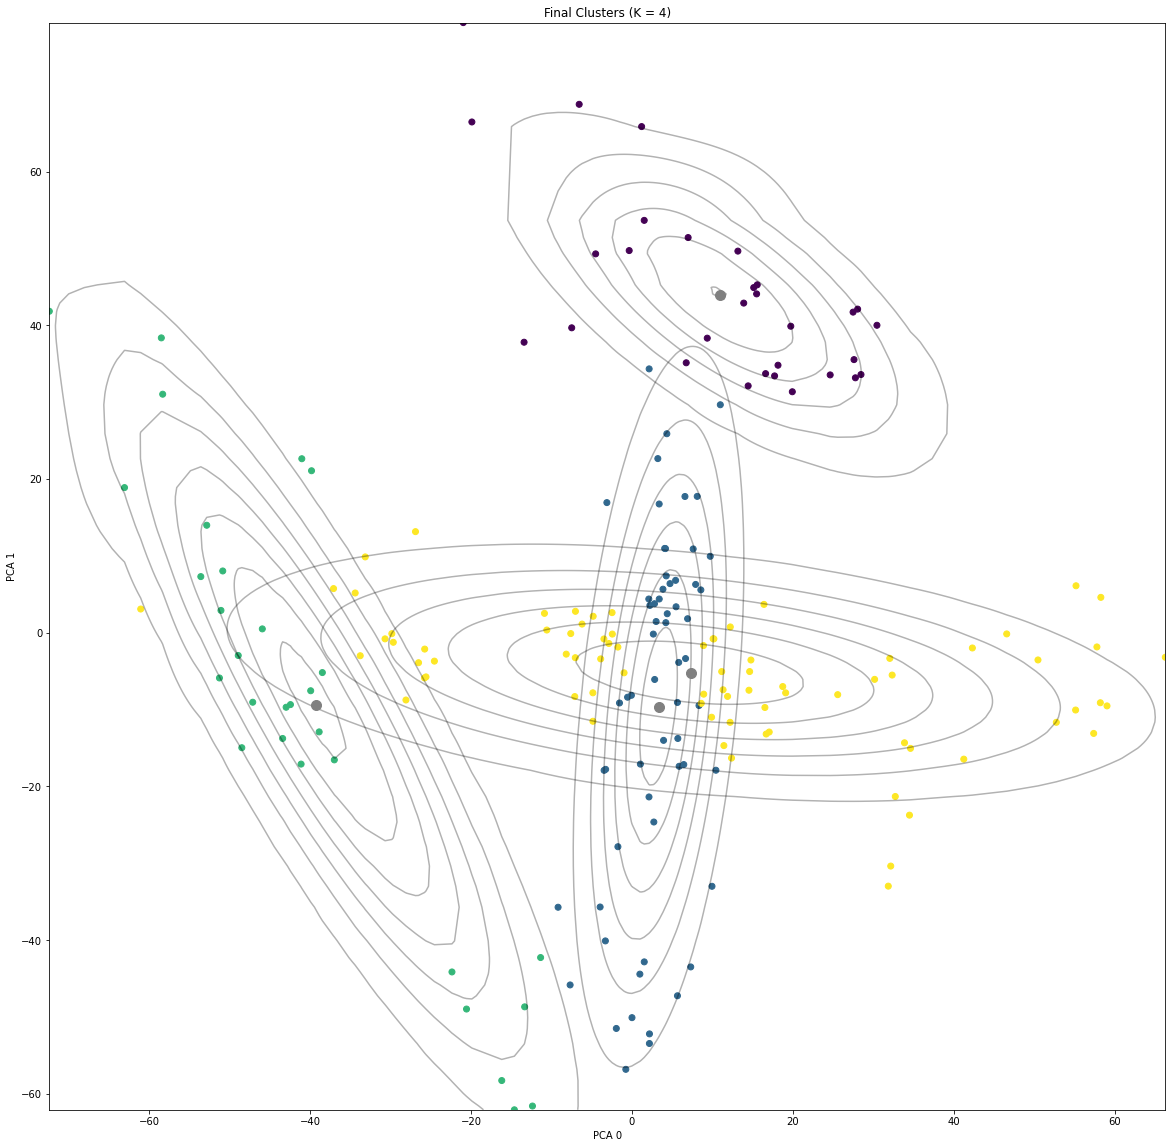

5


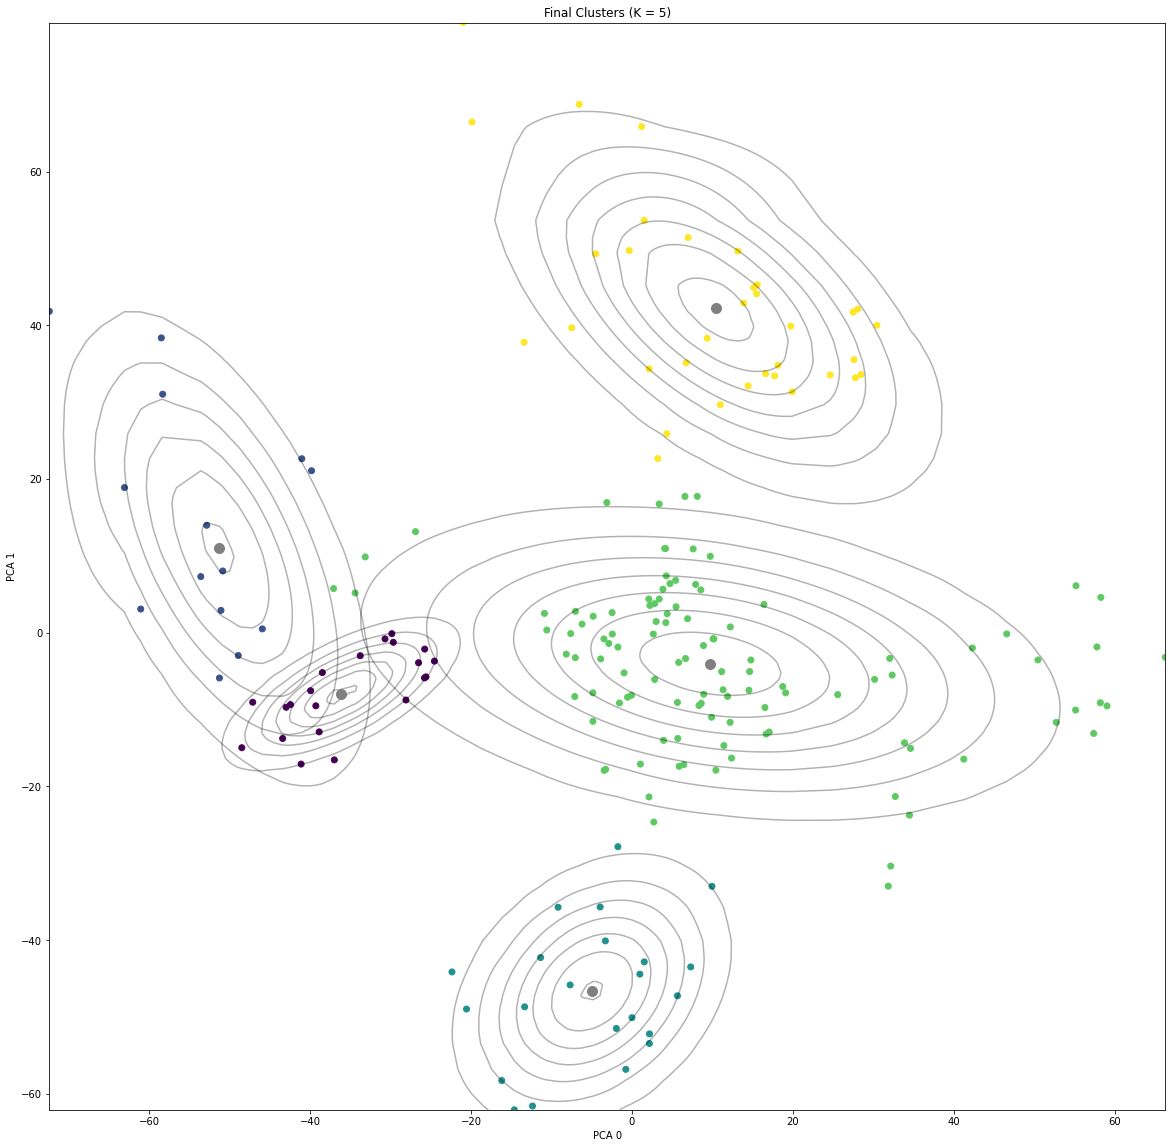

6


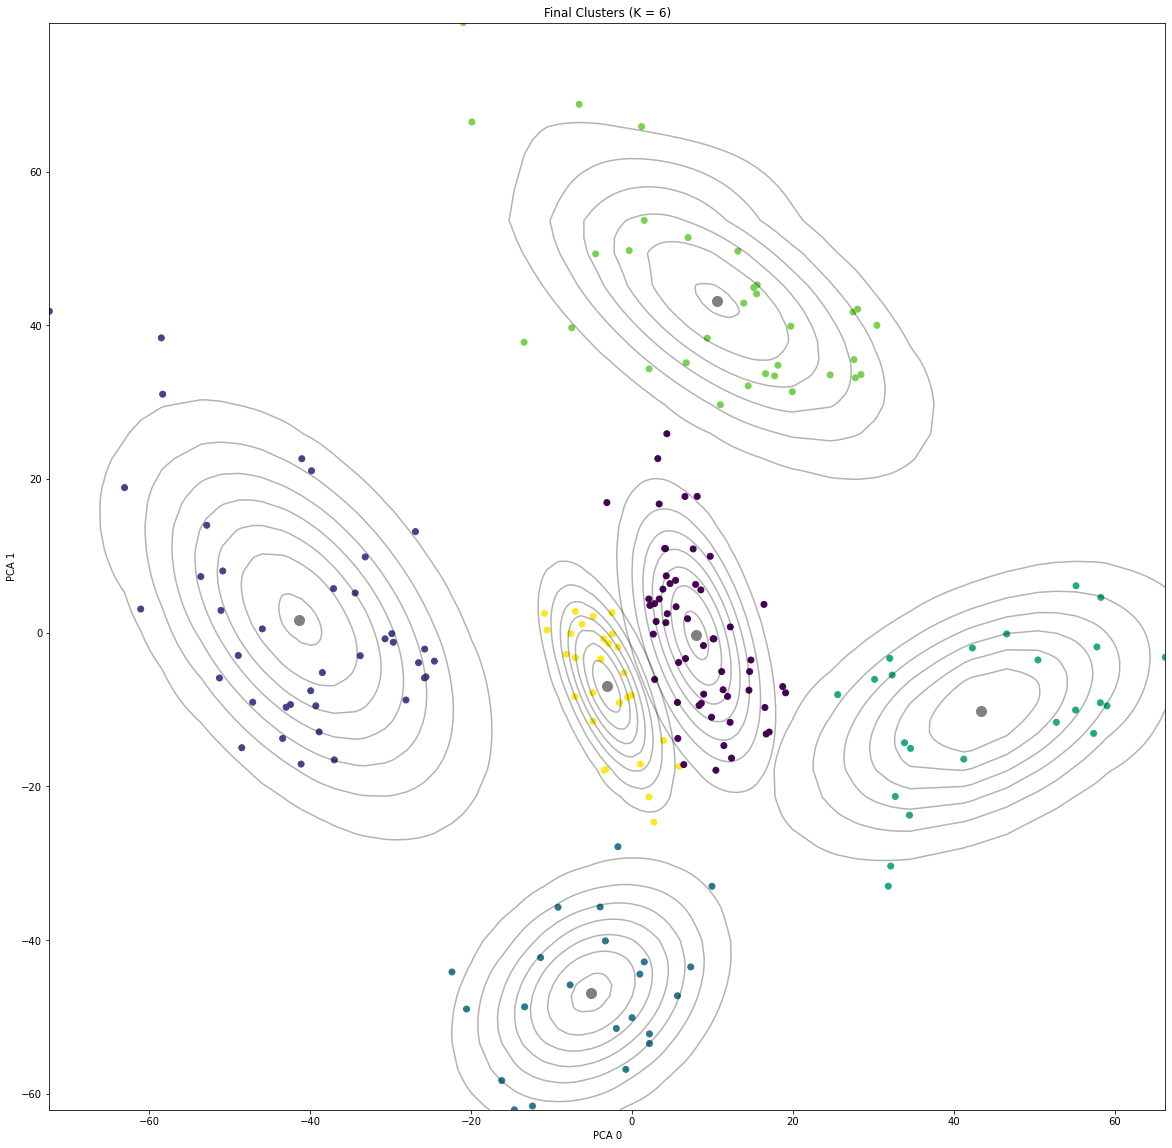

7


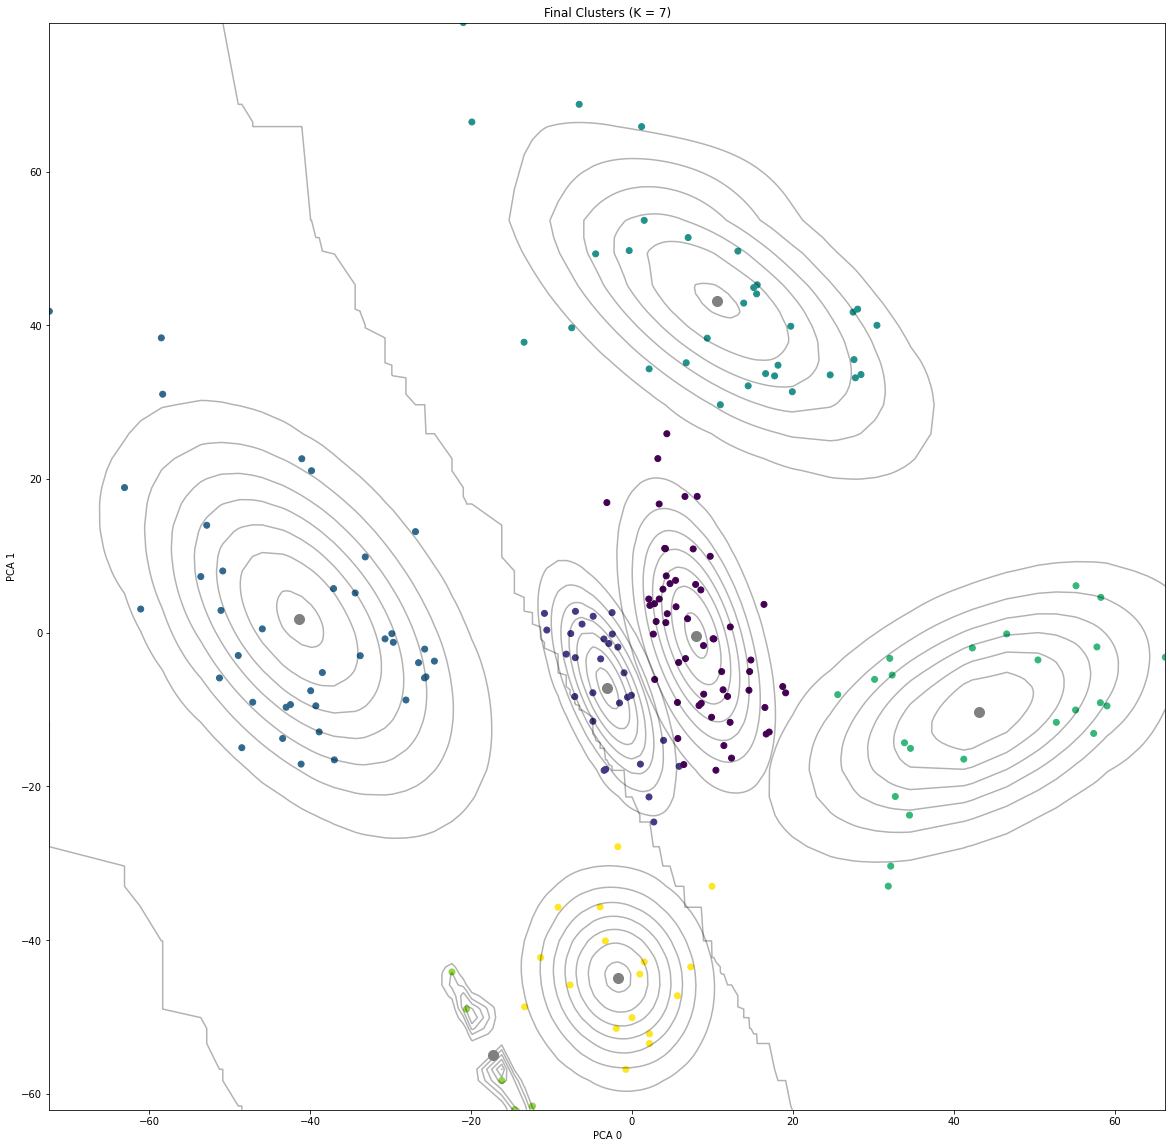

8


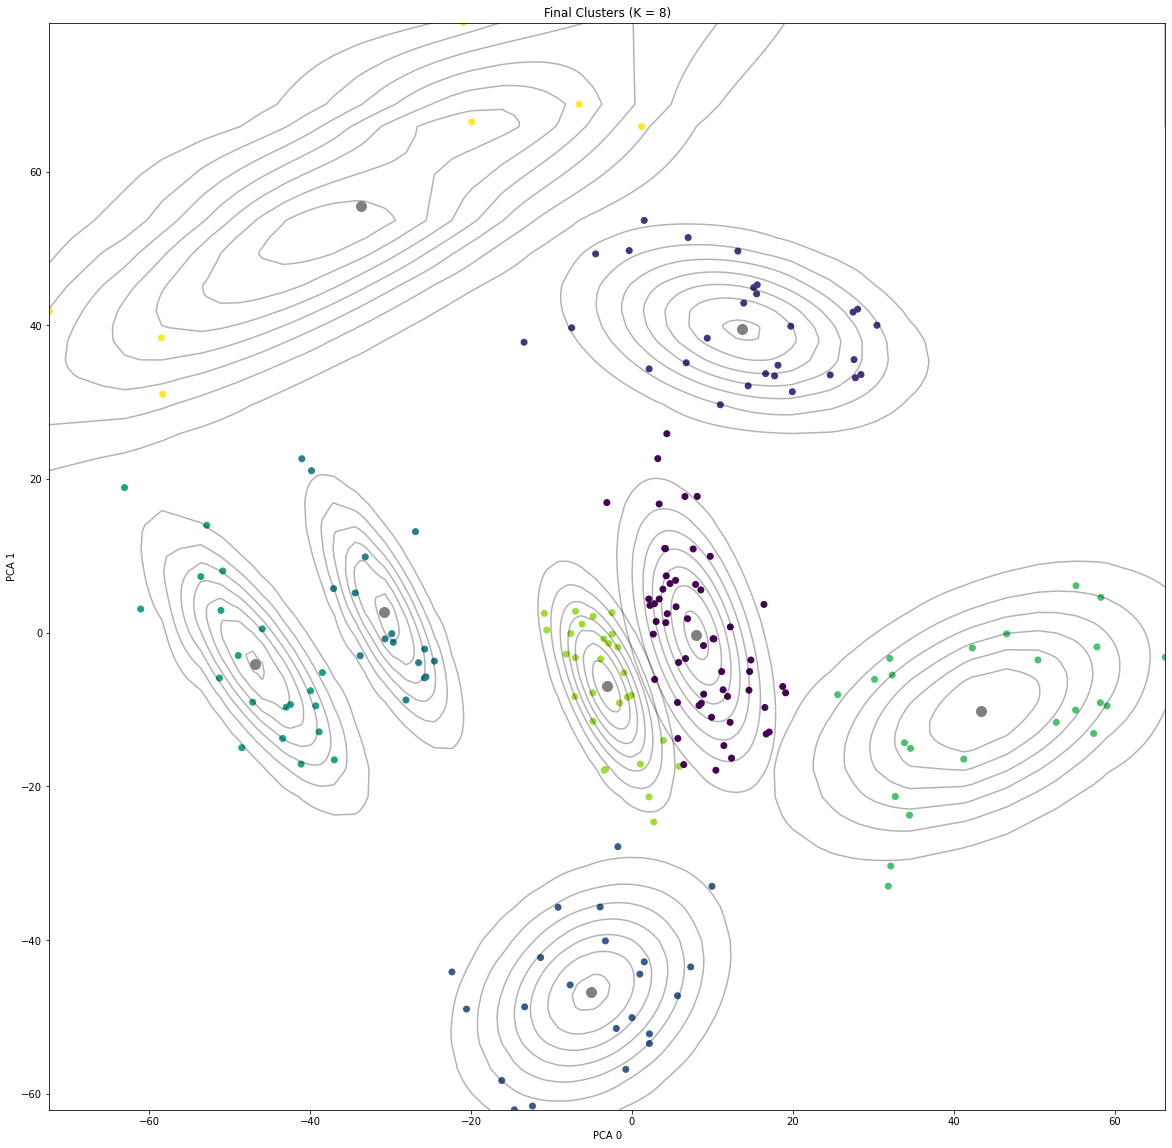

9


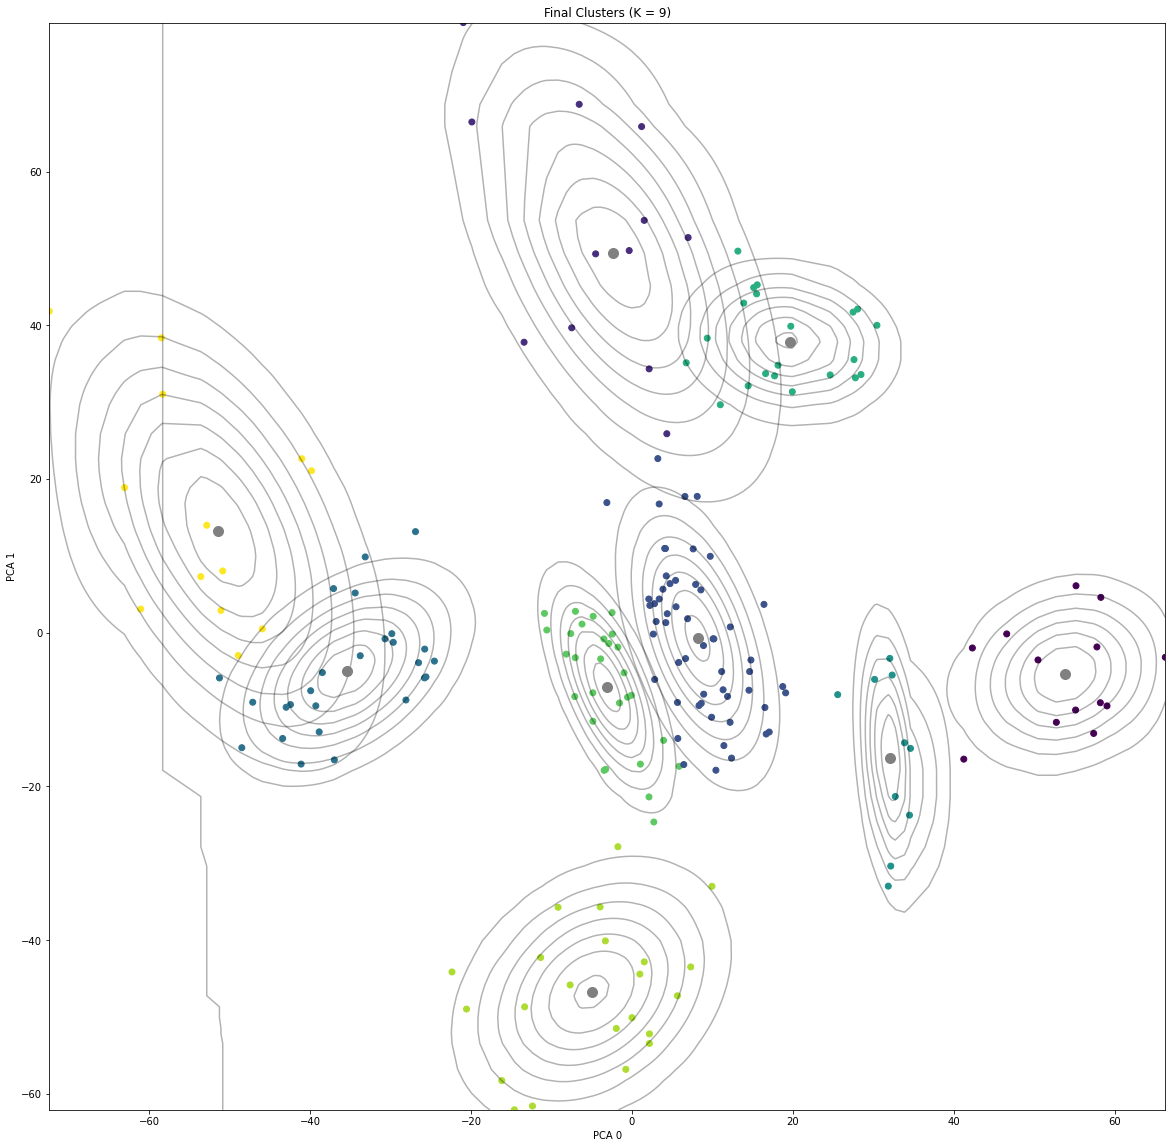

10


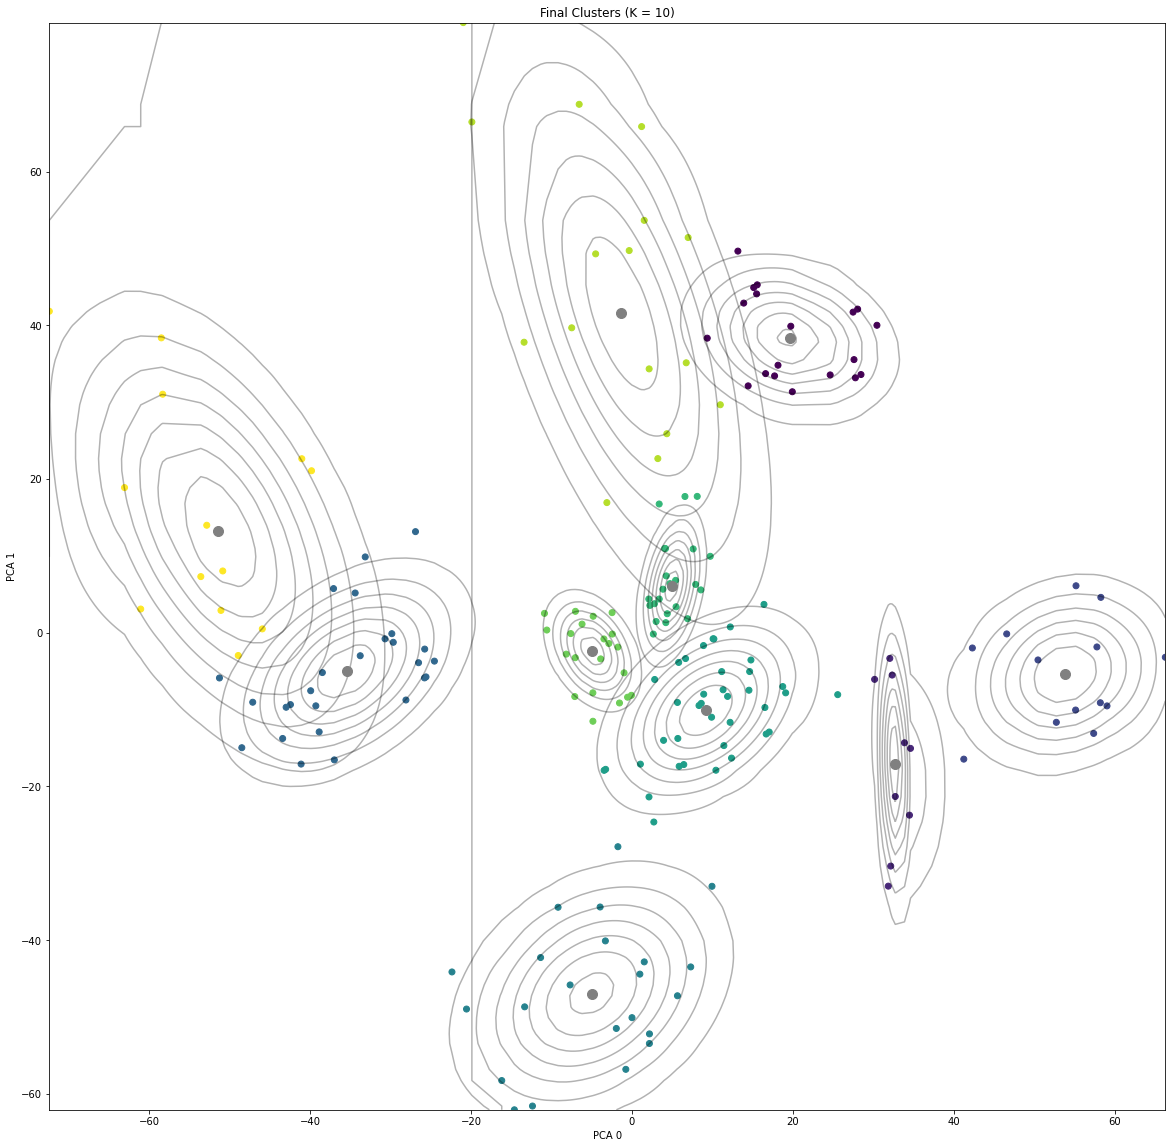

In [66]:
heart_pc_unnorm = (heart - heart_mean) @ h_eigvecs
errors = []
for k in range(1, 11):
    # get the mean obtained from k-means
    mu_init = (k_means_mus[k-1] - heart_mean) @ h_eigvecs
    print(k)
    model = EMModel(heart_pc_unnorm[:, 0:2], k, max_iters=1000, mu_init=mu_init[:, 0:2])
    model.run()
    errors.append(model.calc_error())

In [51]:
errors

[275535.01342265744,
 190034.8356342655,
 134625.16507381358,
 143878.89292672146,
 76679.3724890156,
 42552.85550886417,
 41156.33802615355,
 35247.643546334046,
 26544.873866535858,
 24362.116218334166]

Text(0, 0.5, 'SSE')

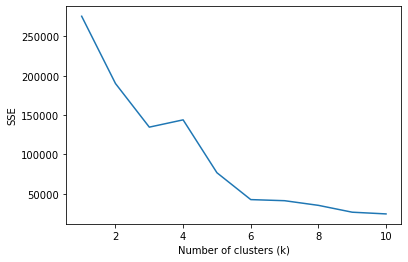

In [53]:
plt.plot(K_range, errors)
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')

# Messing Around (cut out)

In [22]:
from sklearn.manifold import TSNE

heart_tsne = TSNE(init='pca', learning_rate='auto').fit_transform(heart)

UFuncTypeError: ufunc 'multiply' did not contain a loop with signature matching types (dtype('<U32'), dtype('<U32')) -> dtype('<U32')

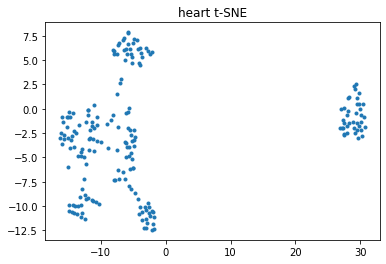

In [ ]:
heart_tsne
plt.scatter(heart_tsne.T[0], heart_tsne.T[1], marker=".")
plt.title("heart t-SNE")
# plt.xlabel("x")
# plt.ylabel("y")
plt.show()